In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata
import scipy.stats as stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp

In [3]:
### load the L2 PIB, PGC, L3 expert, buoy cross track fits and buoy SSH data

swot = xr.open_mfdataset('SWOT_products_at_buoys.nc')
buoy = xr.open_dataset('GNSS_at_SWOT_times.nc')
buoy_xt_cor = xr.open_mfdataset('GNSS_derived_xt_correction.nc')

# create swot time array
swot_time = swot.time.values

In [4]:
### apply corrections to SWOT SSH to make it comparable to buoys (solid earth, SE of pole tide, ocean tidal loading) for both PGC and PIB

h2 = 0.6207
k2 = 0.302
pole_factor = h2 / (1 + k2)

swot['ssh_comparison'] = swot.PGC_ssh_karin_2 - swot.PGC_solid_earth_tide - swot.PGC_load_tide_fes - swot.PGC_pole_tide * pole_factor
swot['ssh_comparison_PIB'] = swot.PIB_ssh_karin_2 - swot.PIB_solid_earth_tide - swot.PIB_load_tide_fes - swot.PIB_pole_tide * pole_factor

# apply quality flag, preserving points at buoy closest to the coast which would otherwise be discarded
swot['ssh_comparison'] = swot['ssh_comparison'].where(swot.PGC_ssh_karin_2_qual < 257)
swot['ssh_comparison_PIB'] = swot['ssh_comparison_PIB'].where(swot.PIB_ssh_karin_2_qual < 257)

# apply quality flag to PGC0 and L3 cross over corrections (but not PIB as this removed almost all the data)
swot['PGC_height_cor_xover'] = swot['PGC_height_cor_xover'].where(swot.PGC_height_cor_xover_qual < 1)
swot['L3_calibration'] = swot['L3_calibration'].where(swot.L3_quality_flag < 1)

# apply quality flag to buoy
buoy['ssh'] = buoy['ssh'].where(buoy.ssh_quality <2)

In [5]:
### calculate residuals for cycles with data from at least 7 buoys

PIB_resid = (swot.PIB_height_cor_xover.values + swot.ssh_comparison_PIB) - buoy.ssh.values
PGC_resid = (swot.PGC_height_cor_xover.values + swot.ssh_comparison) - buoy.ssh.values
L3_resid = (swot.L3_calibration.values + swot.ssh_comparison) - buoy.ssh.values
linear_resid = (swot.ssh_comparison - buoy_xt_cor.linear_fit) - buoy.ssh.values
plane_resid = (swot.ssh_comparison - buoy_xt_cor.plane_fit) - buoy.ssh.values

for i in range(96):
    if len(buoy.ssh[:,i].values[~np.isnan(buoy.ssh[:,i].values)])<7:
        PIB_resid[:,i] = np.ones((9))*np.nan
        PGC_resid[:,i] = np.ones((9))*np.nan
        L3_resid[:,i] = np.ones((9))*np.nan
        linear_resid[:,i] = np.ones((9))*np.nan
        plane_resid[:,i] = np.ones((9))*np.nan

In [6]:
print('Total std PIB: %0.1f mm' % np.nanstd(PIB_resid*1000))
print('Total std PGC: %0.1f mm' % np.nanstd(PGC_resid*1000))
print('Total std L3: %0.1f mm' % np.nanstd(L3_resid*1000))
print('Total std linear fit: %0.1f mm' % np.nanstd(linear_resid*1000))
print('Total std plane fit: %0.1f mm' % np.nanstd(plane_resid*1000))

Total std PIB: 88.2 mm
Total std PGC: 36.2 mm
Total std L3: 36.2 mm
Total std linear fit: 12.5 mm
Total std plane fit: 11.1 mm


In [7]:
### remove 1.5 * IQR outliers

PIB_resid_clean = remove_outliers_IQR(PIB_resid.values, 1.5)
PGC_resid_clean = remove_outliers_IQR(PGC_resid.values, 1.5)
L3_resid_clean = remove_outliers_IQR(L3_resid.values, 1.5)
linear_resid_clean = remove_outliers_IQR(linear_resid.values, 1.5)
plane_resid_clean = remove_outliers_IQR(plane_resid.values, 1.5)

Removed 13 / 864 points
Removed 12 / 864 points
Removed 10 / 864 points
Removed 21 / 864 points
Removed 18 / 864 points


In [8]:
print('Total std PIB clean: %0.1f mm' % np.nanstd(PIB_resid_clean*1000))
print('Total std PGC clean: %0.1f mm' % np.nanstd(PGC_resid_clean*1000))
print('Total std L3 clean: %0.1f mm' % np.nanstd(L3_resid_clean*1000))
print('Total std linear fit clean: %0.1f mm' % np.nanstd(linear_resid_clean*1000))
print('Total std plane fit clean: %0.1f mm' % np.nanstd(plane_resid_clean*1000))

Total std PIB clean: 59.4 mm
Total std PGC clean: 34.1 mm
Total std L3 clean: 34.2 mm
Total std linear fit clean: 11.1 mm
Total std plane fit clean: 9.9 mm


In [9]:
### calculate daily std for each dataset

PIB_resid_clean_daily_std = np.nanstd(PIB_resid_clean, axis=0)
PGC_resid_clean_daily_std = np.nanstd(PGC_resid_clean, axis=0)
L3_resid_clean_daily_std = np.nanstd(L3_resid_clean, axis=0)
linear_resid_clean_daily_std = np.nanstd(linear_resid_clean, axis=0)
plane_resid_clean_daily_std = np.nanstd(plane_resid_clean, axis=0)


/working/hendreya/python_venvs/for_xarray/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [10]:
### calculate slope, fit, and non linear residual for each

PIB_xtcor_slope = []
PIB_xtcor_fit = []
PIB_xtcor_non_lin_resid = []
PGC_xtcor_slope = []
PGC_xtcor_fit = []
PGC_xtcor_non_lin_resid = []
L3_xtcor_slope = []
L3_xtcor_fit = []
L3_xtcor_non_lin_resid = []


for i in range(len(swot.time)):
    try:
        y = swot.PIB_height_cor_xover[:,i].values*100
        x = swot.PGC_cross_track_distance[:,i].values/1000
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        slope, intercept = np.polyfit(x, y, 1)
        PIB_xtcor_slope.append(slope)
        y_fitted = slope * x + intercept
        PIB_xtcor_fit.append(y_fitted)
        y_cor = y - y_fitted
        PIB_xtcor_non_lin_resid.append(y_cor)
    except:
        PIB_xtcor_slope.append(np.nan)
        PIB_xtcor_fit.append(np.ones(9)*np.nan)
        PIB_xtcor_non_lin_resid.append(np.ones(9)*np.nan)
     
for i in range(len(swot.time)):
    try:
        y = swot.PGC_height_cor_xover[:,i].values*100
        x = swot.PGC_cross_track_distance[:,i].values/1000
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        slope, intercept = np.polyfit(x, y, 1)
        PGC_xtcor_slope.append(slope)
        y_fitted = slope * x + intercept
        PGC_xtcor_fit.append(y_fitted)
        y_cor = y - y_fitted
        PGC_xtcor_non_lin_resid.append(y_cor)
    except:
        PGC_xtcor_slope.append(np.nan)
        PGC_xtcor_fit.append(np.ones(9)*np.nan)
        PGC_xtcor_non_lin_resid.append(np.ones(9)*np.nan)
    
     
for i in range(len(swot.time)):
    try:
        y = swot.L3_calibration[:,i].values*100
        x = swot.PGC_cross_track_distance[:,i].values/1000
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        slope, intercept = np.polyfit(x, y, 1)
        L3_xtcor_slope.append(slope)
        y_fitted = slope * x + intercept
        L3_xtcor_fit.append(y_fitted)
        y_cor = y - y_fitted
        L3_xtcor_non_lin_resid.append(y_cor)
    except:
        L3_xtcor_slope.append(np.nan)
        L3_xtcor_fit.append(np.ones(9)*np.nan)
        L3_xtcor_non_lin_resid.append(np.ones(9)*np.nan)
     
PIB_xtcor_slope = np.array(PIB_xtcor_slope)
PIB_xtcor_fit = np.array(PIB_xtcor_fit)
PIB_xtcor_non_lin_resid = np.array(PIB_xtcor_non_lin_resid)
PGC_xtcor_slope = np.array(PGC_xtcor_slope)
PGC_xtcor_fit = np.array(PGC_xtcor_fit)
PGC_xtcor_non_lin_resid = np.array(PGC_xtcor_non_lin_resid)
L3_xtcor_slope = np.array(L3_xtcor_slope)
L3_xtcor_fit = np.array(L3_xtcor_fit)
L3_xtcor_non_lin_resid = np.array(L3_xtcor_non_lin_resid)

/tmp/ipykernel_1564368/3399885623.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L3_xtcor_fit = np.array(L3_xtcor_fit)
/tmp/ipykernel_1564368/3399885623.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L3_xtcor_non_lin_resid = np.array(L3_xtcor_non_lin_resid)


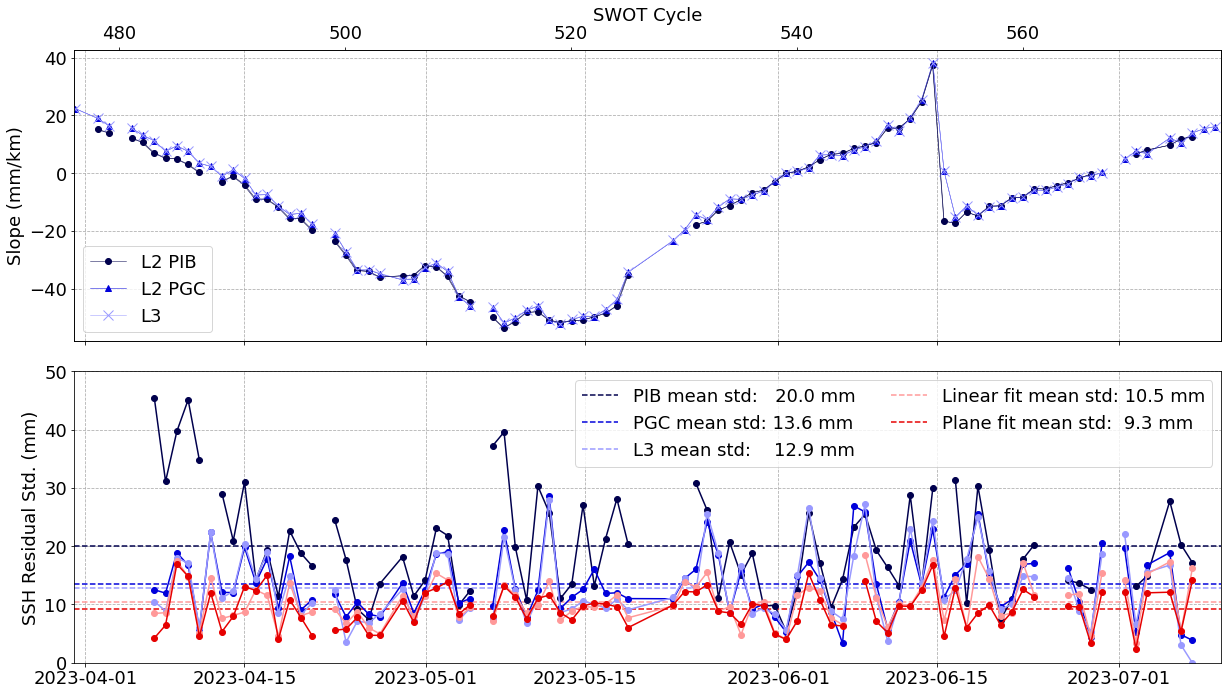

In [11]:
### plot the results

# create a 5 point array of colors
line_col = plt.cm.seismic(np.linspace(0, 1, 6))

fig_width = 17.4 #*cm
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(2, figsize=(fig_width,10), sharex=True)

axes = [ax[0], ax[0].twiny()]
ax[0].plot(swot.time, PIB_xtcor_slope*10, marker='o', label='L2 PIB', lw=0.5, c=line_col[0])
axes[1].plot(swot.swot_cycle, PIB_xtcor_slope*10, label='L2 PIB', lw=0.5, c=line_col[0], zorder=1)
ax[0].plot(swot.time, PGC_xtcor_slope*10, marker='^', label='L2 PGC', lw=0.5,  c=line_col[1], zorder=10)
ax[0].plot(swot.time, L3_xtcor_slope*10, marker='x', label='L3', lw=0.5, c=line_col[2], markersize=10, zorder=10)
ax[0].grid(linestyle='--')
axes[1].set_xlabel('SWOT Cycle')
axes[1].set_xlim(476, 577.55)
ax[0].set_xlim(swot_time[0], np.datetime64('2023-07-10'))
ax[0].set_ylabel('Slope (mm/km)')
ax[0].legend()

ax[1].axhline(y = np.nanmean(PIB_resid_clean_daily_std*1000), linestyle='--', c=line_col[0], label=('PIB mean std:   %0.1f mm' % np.nanmean(PIB_resid_clean_daily_std*1000)))
ax[1].axhline(y = np.nanmean(PGC_resid_clean_daily_std*1000), linestyle='--', c=line_col[1], label=('PGC mean std: %0.1f mm' % np.nanmean(PGC_resid_clean_daily_std*1000)))
ax[1].axhline(y = np.nanmean(L3_resid_clean_daily_std*1000), linestyle='--', c=line_col[2], label=('L3 mean std:    %0.1f mm' % np.nanmean(L3_resid_clean_daily_std*1000)))
ax[1].axhline(y = np.nanmean(linear_resid_clean_daily_std*1000), linestyle='--', c=line_col[3], label=('Linear fit mean std: %0.1f mm' % np.nanmean(linear_resid_clean_daily_std*1000)))
ax[1].axhline(y = np.nanmean(plane_resid_clean_daily_std*1000), linestyle='--', c=line_col[4], label=('Plane fit mean std:  %0.1f mm' % np.nanmean(plane_resid_clean_daily_std*1000)))

ax[1].plot(swot_time, PIB_resid_clean_daily_std*1000, marker='o', c=line_col[0])
ax[1].plot(swot_time, PGC_resid_clean_daily_std*1000, marker='o', c=line_col[1])
ax[1].plot(swot_time, L3_resid_clean_daily_std*1000, marker='o', c=line_col[2])
ax[1].plot(swot_time, linear_resid_clean_daily_std*1000, marker='o', c=line_col[3])
ax[1].plot(swot_time, plane_resid_clean_daily_std*1000, marker='o', c=line_col[4])

ax[1].legend(ncol=2)#bbox_to_anchor=(0.12,0.53))
ax[1].set_xlim(np.datetime64('2023-03-31'), np.datetime64('2023-07-10'))
ax[1].set_ylabel('SSH Residual Std. (mm)')
ax[1].grid(linestyle='--')
ax[1].set_ylim(0,50)

plt.tight_layout()
plt.show()
